Popularne instancje QAP wraz z dokladnym minimum funkcji celu
  *  Nug12   12    578 (OPT)    (12,7,9,3,4,8,11,1,5,6,10,2)

 *   Nug14   14   1014 (OPT)    (9,8,13,2,1,11,7,14,3,4,12,5,6,10)

 *   Nug15   15   1150 (OPT)    (1,2,13,8,9,4,3,14,7,11,10,15,6,5,12)

 *   Nug16a  16   1610 (OPT)    (9,14,2,15,16,3,10,12,8,11,6,5,7,1,4,13)

 *   Nug16b  16   1240 (OPT)    (16,12,13,8,4,2,9,11,15,10,7,3,14,6,1,5)

 *   Nug17   17   1732 (OPT)    (16,15,2,14,9,11,8,12,10,3,4,1,7,6,13,17,5)

 *   Nug18   18   1930 (OPT)    (10,3,14,2,18,6,7,12,15,4,5,1,11,8,17,13,9,16)

 *   Nug20   20   2570 (OPT)    (18,14,10,3,9,4,2,12,11,16,19,15,20,8,13,17,5,7,1,6)

 *   Nug21   21   2438 (OPT)    (4,21,3,9,13,2,5,14,18,11,16,10,6,15,20,19,8,7,1,12,17)

 *   Nug22   22   3596 (OPT)    (2,21,9,10,7,3,1,19,8,20,17,5,13,6,12,16,11,22,18,14,15)

 *   Nug24   24   3488 (OPT)    (17,8,11,23,4,20,15,19,22,18,3,14,1,10,7,9,16,21,24,12,6,13,5,2)

 *   Nug25   25   3744 (OPT)    (5,11,20,15,22,2,25,8,9,1,18,16,3,6,19,24,21,14,7,10,17,12,4,23,13)

*  Nug27   27   5234 (OPT)    (23,18,3,1,27,17,5,12,7,15,4,26,8,19,20,2,24,21,14,10,9,13,22,25,6,16,11)

*  Nug28   28   5166 (OPT)    (18,21,9,1,28,20,11,3,13,12,10,19,14,22,15,2,25,16,4,23,7,17,24,26,5,27,8,6)

*  Nug30   30   6124 (OPT)    (5 12 6 13 2 21 26 24 10 9 29 28 17 1 8 7 19 25 23 22 11 16 30 4 15 18 27 3 14 20)

In [2]:
best_answers = {
    "nug12": 578,
    "nug14": 1014,
    "nug15": 1150,
    "nug16a": 1610,
    "nug16b": 1240,
    "nug17": 1732,
    "nug18": 1930,
    "nug20": 2570,
    "nug21": 2438,
    "nug22": 3596,
    "nug24": 3488,
    "nug25": 3744,
    "nug27": 5234,
    "nug28": 5166,
    "nug30": 6124,
}

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import urllib
import threading
from itertools import combinations

%matplotlib inline

In [4]:
def get_QAP(instance_url):
    qap_instance_file = urllib.request.urlopen(instance_url)
    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])

    A = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))
    B = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        B[i, :] = list(map(int, line.decode()[:-1].split()))

    return n, A, B

In [5]:
def qap_objective_function(p, n, A, B):
    s = 0.0
    for i in range(n):
        s += (A[i, :] * B[p[i], p]).sum()
    return s

def random_neighbor(p, radius, n):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

In [6]:
def PMX(ind1, ind2, separator_no=2):
    new_ind1, new_ind2 = ind1.copy(), ind2.copy()
    idxs = sorted(np.random.choice(len(ind1), separator_no, replace=False))

    group = np.random.choice(separator_no-1)
    start, end = idxs[group], idxs[group+1]

    tmp = ind1[start:end].copy()
    ind1[start:end] = ind2[start:end]
    ind2[start:end] = tmp

    for i in range(len(ind1)):
        if start <= i < end:
            continue

        while ind1[i] in ind1[start:end]:
            idx_of_elem = np.nonzero(ind1[start:end] == ind1[i])[0][0]
            ind1[i] = ind2[start+idx_of_elem]

        while ind2[i] in ind2[start:end]:
            idx_of_elem = np.nonzero(ind2[start:end] == ind2[i])[0][0]
            ind2[i] = ind1[start+idx_of_elem]

    return ind1, ind2

In [7]:
def get_permutations_with_k_differences(perm, K):
    def generate_permutations_with_swaps(perm, indices):
        # Base case: If no indices, yield the original permutation
        if not indices:
            yield tuple(perm)
            return
        # Generate permutations by swapping each index in `indices` with others in `indices`
        for i in range(len(indices)):
            for j in range(i + 1, len(indices)):
                # Swap elements at indices[i] and indices[j]
                new_perm = perm[:]
                new_perm[indices[i]], new_perm[indices[j]] = new_perm[indices[j]], new_perm[indices[i]]
                yield tuple(new_perm)

    perm = list(perm)
    n = len(perm)
    unique_permutations = set()

    # Iterate over all combinations of indices with sizes from 1 to K
    for k in range(1, K + 1):
        for indices in combinations(range(n), k):
            # Generate and collect unique permutations with swaps at `indices`
            unique_permutations.update(generate_permutations_with_swaps(perm, indices))

    # Return as a list for easy usage
    return [np.array(perm) for perm in unique_permutations]

In [8]:
def reverse_sequence_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q
    
def local_search_mutation(chromosome, K, n, A, B):
    best_chromosome = chromosome.copy()
    best_value = qap_objective_function(chromosome, n, A, B)

    possible_permutations = get_permutations_with_k_differences(chromosome, K)
    for neighbor in possible_permutations:
        neighbor_value = qap_objective_function(neighbor, n, A, B)
        
        if neighbor_value < best_value:
            best_value = neighbor_value
            best_chromosome = neighbor

    return best_chromosome

def iterative_local_search_mutation(chromosome, K, n, A, B):
    improved = True
    while improved:
        improved = False
        current_value = qap_objective_function(chromosome, n, A, B)
        new_chromosome = local_search_mutation(chromosome, K, n, A, B)
        new_value = qap_objective_function(new_chromosome, n, A, B)
        
        if new_value < current_value:
            chromosome = new_chromosome
            improved = True

    return chromosome

In [9]:
def SGA(n, A, B, number_of_iterations=250):
    population_size = 500
    chromosome_length = n
    number_of_offspring = population_size
    crossover_probability = 0.95
    mutation_probability = 0.25
    local_search_mutation_probability = 0.08
    iterative_local_search_mutation_probability = 0.03
    K = 2

    best_objective_value = np.inf
    best_chromosome = np.zeros((1, chromosome_length))
    costs_SGA = np.zeros(number_of_iterations)

    # generating an initial population
    current_population = np.zeros((population_size, chromosome_length), dtype=np.int64)
    for i in range(population_size):
        current_population[i, :] = np.random.permutation(chromosome_length)

    # evaluating the objective function on the current population
    objective_values = np.zeros(population_size)
    for i in range(population_size):
        objective_values[i] = qap_objective_function(current_population[i, :], n, A, B)

    for t in tqdm(range(number_of_iterations)):
        # selecting the parent indices by the roulette wheel method
        fitness_values = objective_values.max() - objective_values
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(population_size) / population_size
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)
        # creating the children population
        children_population = np.zeros((number_of_offspring, chromosome_length), dtype=np.int64)
        for i in range(int(number_of_offspring/2)):
            if np.random.random() < crossover_probability:
                children_population[2*i, :], children_population[2*i+1, :] = PMX(current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1], :].copy())
            else:
                children_population[2*i, :], children_population[2*i+1, :] = current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1]].copy()

        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1, :] = current_population[parent_indices[-1], :]

        # mutating the children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i, :] = reverse_sequence_mutation(children_population[i, :])
            if np.random.random() < local_search_mutation_probability:
                children_population[i, :] = local_search_mutation(children_population[i, :], K, n, A, B)
            elif np.random.random() < iterative_local_search_mutation_probability:
                children_population[i, :] = iterative_local_search_mutation(children_population[i, :], K, n, A, B)

        # evaluating the objective function on the children population
        children_objective_values = np.zeros(number_of_offspring)
        for i in range(number_of_offspring):
            children_objective_values[i] = qap_objective_function(children_population[i, :], n, A, B)

        # replacing the current population by (Mu + Lambda) Replacement
        objective_values = np.hstack([objective_values, children_objective_values])
        current_population = np.vstack([current_population, children_population])

        I = np.argsort(objective_values)
        current_population = current_population[I[:population_size], :]
        objective_values = objective_values[I[:population_size]]

        # recording some statistics
        if best_objective_value < objective_values[0]:
            best_objective_value = objective_values[0]
            best_chromosome = current_population[0, :]
        costs_SGA[t] = objective_values.mean()

        #print('%3d %14.8f %12.8f %12.8f %12.8f %12.8f' % (t, time.time() - time0, objective_values.min(), objective_values.mean(), objective_values.max(), objective_values.std()))
    return costs_SGA

In [9]:
tasks = [
    ('https://qaplib.mgi.polymtl.ca/data.d/nug12.dat', 40),
    ('https://qaplib.mgi.polymtl.ca/data.d/nug15.dat', 40),
    ('https://qaplib.mgi.polymtl.ca/data.d/nug17.dat', 40),
    ('https://qaplib.mgi.polymtl.ca/data.d/nug18.dat', 40),
    ('https://qaplib.mgi.polymtl.ca/data.d/nug20.dat', 40),
    ('https://qaplib.mgi.polymtl.ca/data.d/nug21.dat', 40),
    ('https://qaplib.mgi.polymtl.ca/data.d/nug22.dat', 60),
    ('https://qaplib.mgi.polymtl.ca/data.d/nug24.dat', 60),
    ('https://qaplib.mgi.polymtl.ca/data.d/nug25.dat', 60),
    ('https://qaplib.mgi.polymtl.ca/data.d/nug27.dat', 60),
    ('https://qaplib.mgi.polymtl.ca/data.d/nug28.dat', 60),
    # ('https://qaplib.mgi.polymtl.ca/data.d/nug30.dat', 800),
    # ('https://qaplib.mgi.polymtl.ca/data.d/tai50a.dat'),
    # ('https://qaplib.mgi.polymtl.ca/data.d/tai60a.dat'),
    # ('https://qaplib.mgi.polymtl.ca/data.d/tai80a.dat')
]

In [10]:
def run_SGA_plotted(instance_url, number_of_iterations):
    time_start = time.time()
    n, A, B = get_QAP(instance_url)
    costs_SGA = SGA(n, A, B, number_of_iterations)
    time_taken = time.time() - time_start
    best_answer = min(costs_SGA)
    plt.plot(costs_SGA)
    plt.title(f"Problem: {instance_url}, time running: {time_taken:.2f}, best value: {best_answer}, optimal is {best_answers[instance_url.split('/')[-1].split('.')[0]]}, error: {100*(best_answer-best_answers[instance_url.split('/')[-1].split('.')[0]])/best_answers[instance_url.split('/')[-1].split('.')[0]]:.2f}%")
    plt.show()

100%|██████████| 40/40 [00:06<00:00,  5.85it/s]


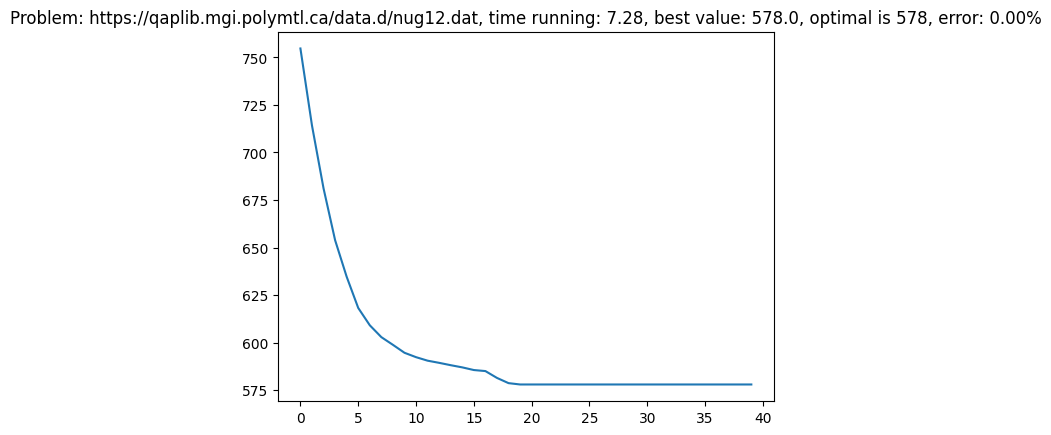

100%|██████████| 40/40 [00:12<00:00,  3.26it/s]


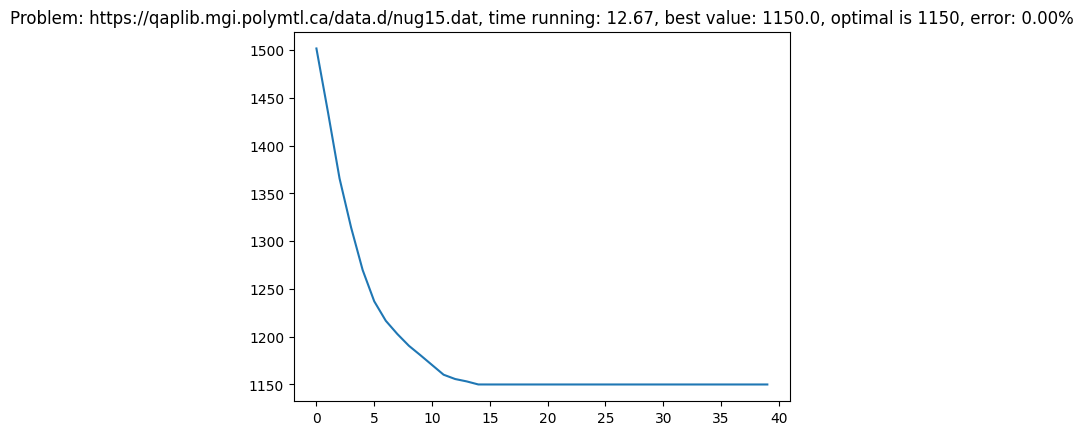

100%|██████████| 40/40 [00:17<00:00,  2.22it/s]


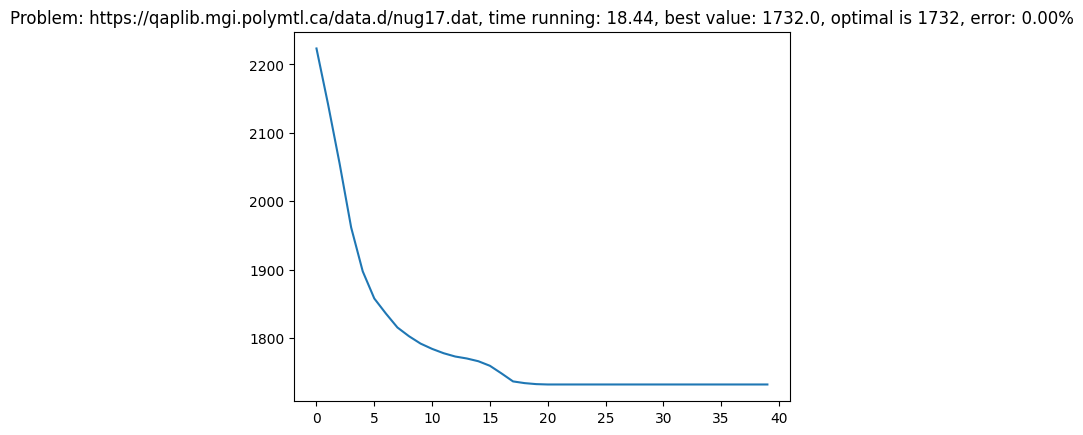

100%|██████████| 40/40 [00:21<00:00,  1.89it/s]


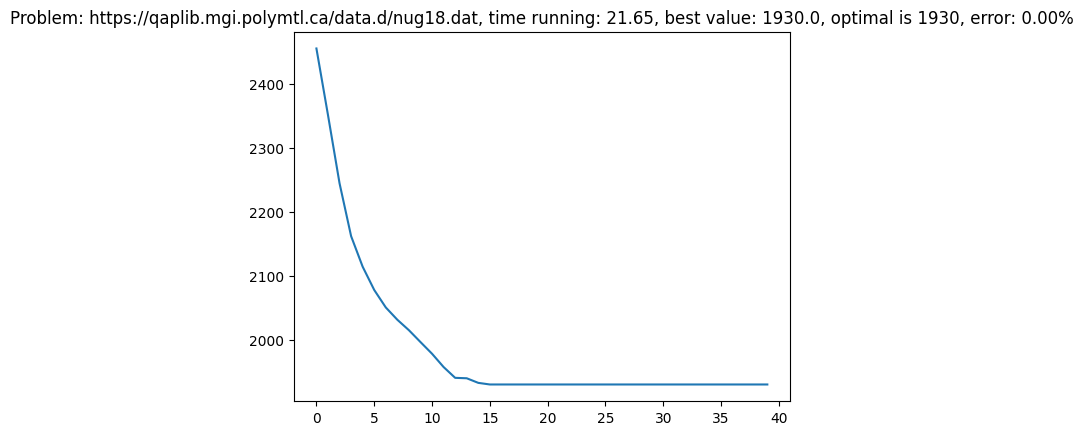

100%|██████████| 40/40 [00:32<00:00,  1.21it/s]


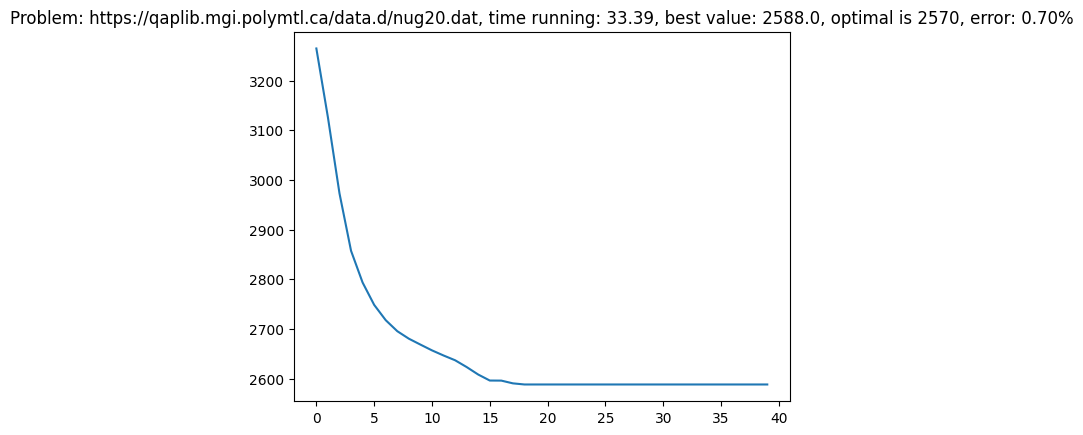

100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


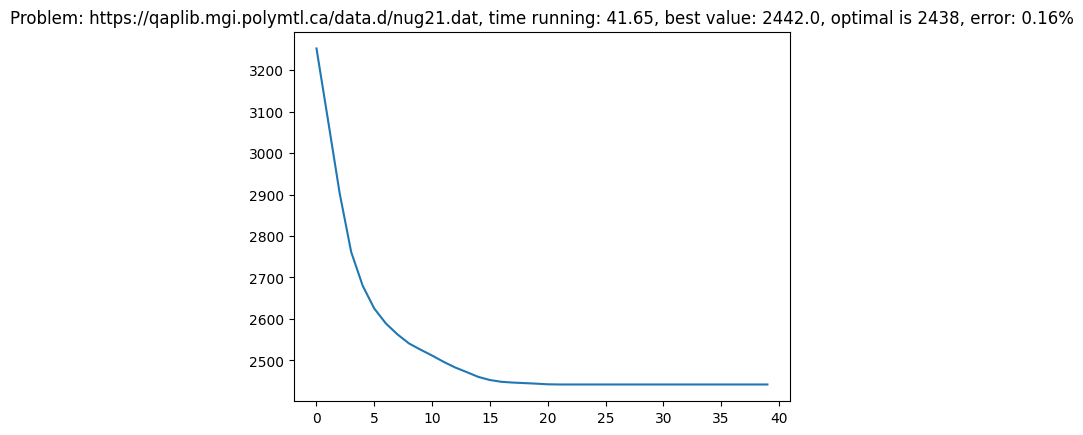

100%|██████████| 60/60 [01:01<00:00,  1.03s/it]


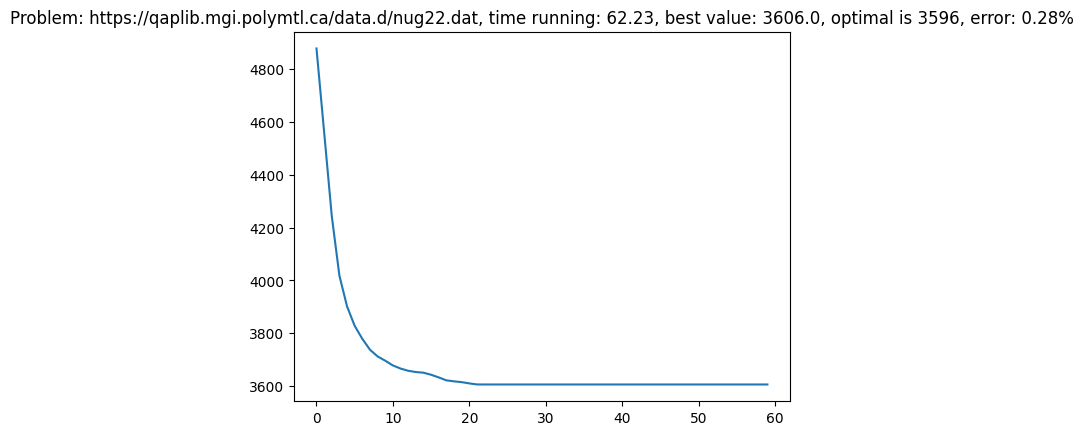

100%|██████████| 60/60 [01:26<00:00,  1.45s/it]


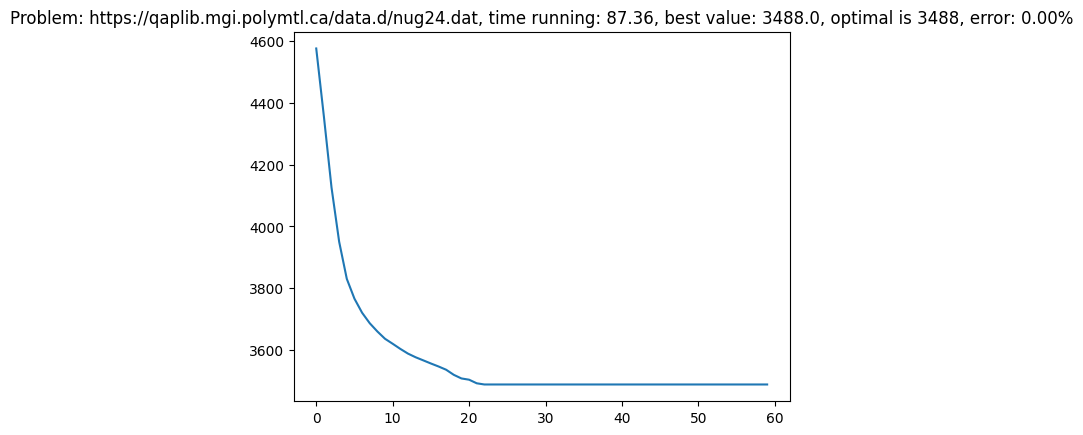

100%|██████████| 60/60 [01:41<00:00,  1.70s/it]


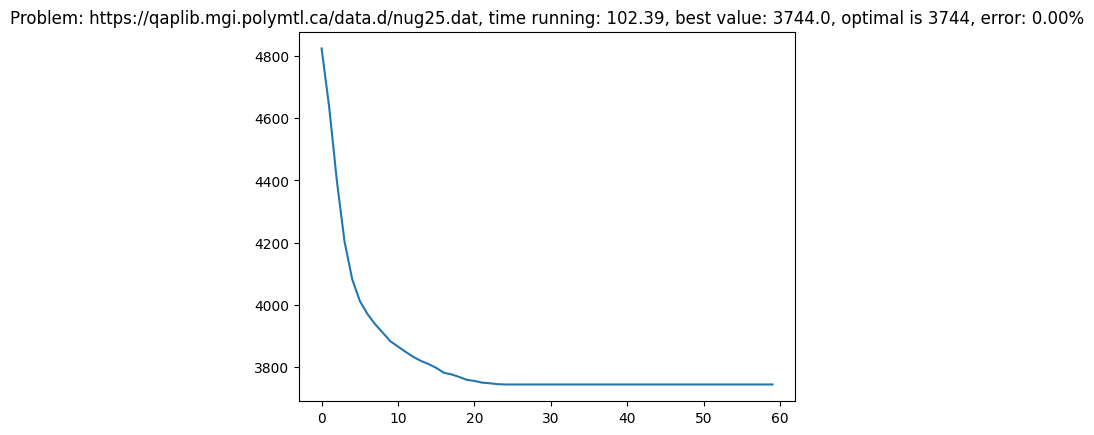

100%|██████████| 60/60 [02:26<00:00,  2.44s/it]


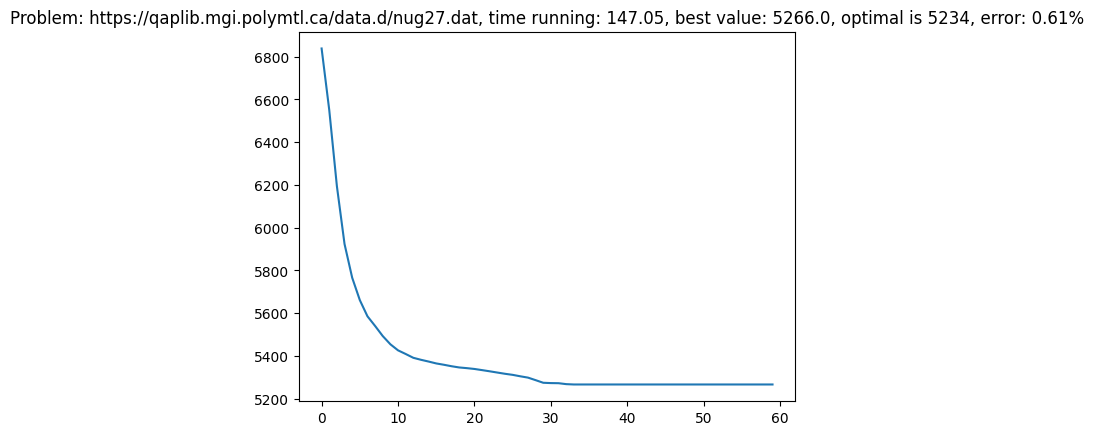

100%|██████████| 60/60 [02:41<00:00,  2.69s/it]


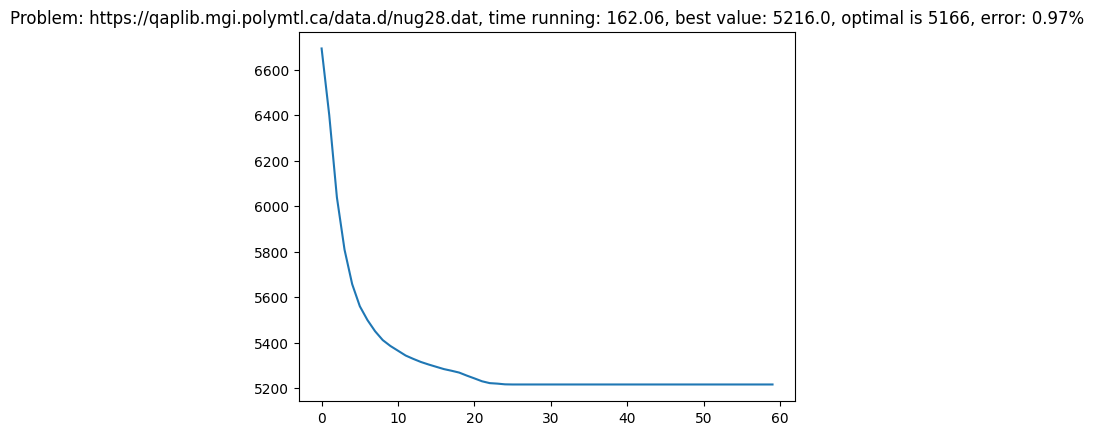

In [11]:
for instance_url, number_of_iterations in tasks:
    run_SGA_plotted(instance_url, number_of_iterations)

In [13]:
tasks2 = [
    ('https://qaplib.mgi.polymtl.ca/data.d/tai50a.dat', 60),
    ('https://qaplib.mgi.polymtl.ca/data.d/tai60a.dat', 85),
    ('https://qaplib.mgi.polymtl.ca/data.d/tai80a.dat', 85)
]

In [11]:
def get_tai50a(instance_url):
    qap_instance_file = urllib.request.urlopen(instance_url)
    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])

    A = np.empty((n, n))
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))
    B = np.empty((n, n))
    for i in range(n):
        line = qap_instance_file.readline()
        B[i, :] = list(map(int, line.decode()[:-1].split()))

    return n, A, B

def get_tai60a(instance_url):
    qap_instance_file = urllib.request.urlopen(instance_url)
    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])

    A = np.empty((n, n))
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))
    B = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        B[i, :] = list(map(int, line.decode()[:-1].split()))

    return n, A, B

100%|██████████| 60/60 [20:49<00:00, 20.82s/it]


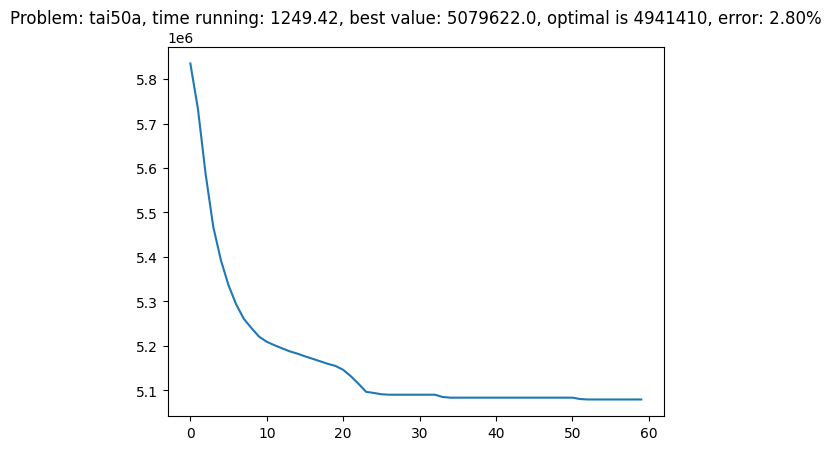

In [14]:
n, A, B = get_tai50a(tasks2[0][0])
number_of_iterations = tasks2[0][1]
time_start = time.time()
costs_SGA = SGA(n, A, B, number_of_iterations)
time_taken = time.time() - time_start
best_answer = min(costs_SGA)
plt.plot(costs_SGA)
plt.title(f"Problem: tai50a, time running: {time_taken:.2f}, best value: {best_answer}, optimal is 4941410, error: {100*(best_answer- 4941410)/ 4941410:.2f}%")
plt.show()

100%|██████████| 85/85 [59:44<00:00, 42.17s/it]  


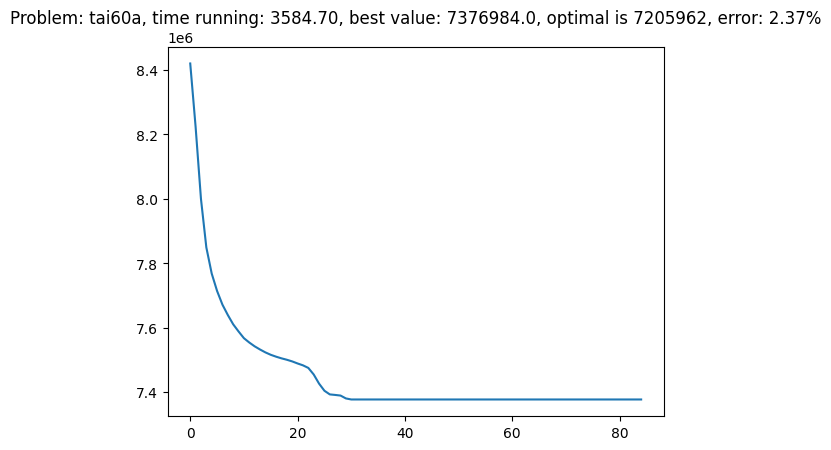

In [12]:
n, A, B = get_tai60a(tasks2[1][0])
number_of_iterations = tasks2[1][1]
time_start = time.time()
costs_SGA = SGA(n, A, B, number_of_iterations)
time_taken = time.time() - time_start
best_answer = min(costs_SGA)
plt.plot(costs_SGA)
plt.title(f"Problem: tai60a, time running: {time_taken:.2f}, best value: {best_answer}, optimal is 7205962, error: {100*(best_answer- 7205962)/ 7205962:.2f}%")
plt.show()

100%|██████████| 85/85 [3:41:03<00:00, 156.04s/it]  


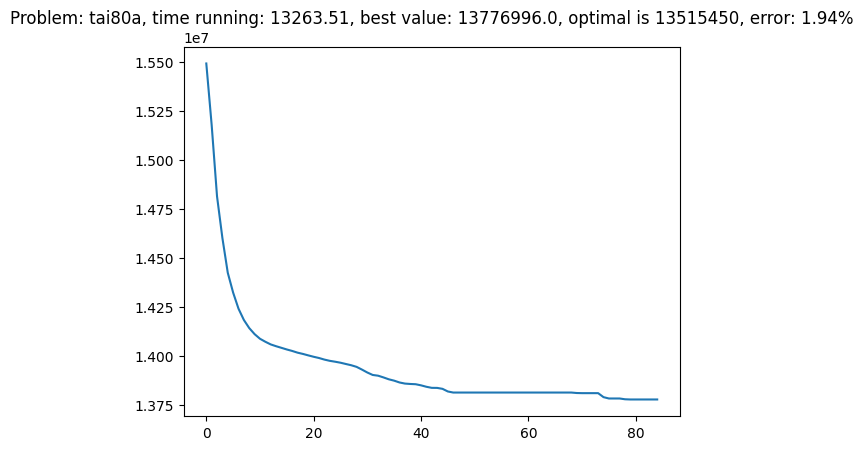

In [14]:
n, A, B = get_tai60a(tasks2[2][0])
number_of_iterations = tasks2[2][1]
time_start = time.time()
costs_SGA = SGA(n, A, B, number_of_iterations)
time_taken = time.time() - time_start
best_answer = min(costs_SGA)
plt.plot(costs_SGA)
plt.title(f"Problem: tai80a, time running: {time_taken:.2f}, best value: {best_answer}, optimal is 13515450, error: {100*(best_answer- 13515450)/ 13515450:.2f}%")
plt.show()